In [20]:
import os
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from corner import corner
from functools import partial

import dynesty
import dynesty.plotting as dyplot

from thesis.io import gyre, fgong
from thesis.physics import sound_speed, acoustic_depth
from thesis.calculus import differentiate
from thesis.glitch import GlitchModel, GlitchPrior, estimate_asy

import jax
import jax.numpy as jnp
from jax import random, tree_util
from jax.scipy.stats import norm, uniform
jax.config.update("jax_enable_x64", True)

import tinygp
from tinygp import kernels, GaussianProcess

rng = random.PRNGKey(0)

In [2]:
root_path = os.path.expanduser("~/OneDrive/Data/MESA/solar_models/y0.28/")
profile_name = "profile"

filename = os.path.join(root_path, ".".join([profile_name, "data", "FGONG"]))
gong = fgong.load_fgong(filename)
gong

<xarray.Dataset>
Dimensions:       (x: 1046)
Coordinates:
  * x             (x) float64 0.0 0.0009072 0.001143 ... 1.001 1.001 1.001
Data variables: (12/36)
    r             (x) float64 0.0 6.399e+07 8.063e+07 ... 7.062e+10 7.062e+10
    ln_q          (x) float64 -708.4 -16.36 -15.67 -14.98 ... 0.0 0.0 0.0 0.0
    T             (x) float64 1.549e+07 1.549e+07 ... 4.78e+03 4.78e+03
    P             (x) float64 2.22e+17 2.22e+17 2.22e+17 ... 95.79 93.64 91.76
    rho           (x) float64 141.5 141.5 141.5 ... 2.945e-10 2.885e-10
    X             (x) float64 0.3762 0.3762 0.3762 ... 0.7304 0.7304 0.7304
    ...            ...
    X_Li7         (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    X_Be7         (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    X_N15         (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    X_O17         (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    X_O18         (x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    X_Ne20        (x) float64 0.002143 0.002143 0.002143 ... 0.001851 0.001851
Attributes: (12/15)
    M:               1.9884098706980504e+33
    R:               70538857450.55437
    L:               3.695049456876695e+33
    initial_Z:       0.02
    initial_X:       0.7
    alpha_MLT:       1.9
    ...              ...
    lambda_surf:     0.0
    d2lnPc_dlnr2:    -125.502754776413
    d2lnrhoc_dlnr2:  -163.89137578671765
    star_age:        4073344465.7814794
    Teff:            5681.793600417881
    G:               6.6743e-08

In [3]:
summary_filename = os.path.join(root_path, profile_name, "summary.h5")
detail_filenames = glob(os.path.join(root_path, profile_name, "detail*"))

pulse = gyre.load_output(summary_filename, detail_filenames)
pulse

<xarray.Dataset>
Dimensions:  (n_pg: 36, l: 3, x: 1046)
Coordinates:
  * n_pg     (n_pg) int64 1 2 3 4 5 6 7 8 9 10 ... 27 28 29 30 31 32 33 34 35 36
  * l        (l) int64 0 1 2
  * x        (x) float64 0.0 0.0009072 0.001143 0.00144 ... 1.001 1.001 1.001
Data variables:
    E_norm   (n_pg, l) float64 0.005267 nan 0.002007 ... 8.809e-09 nan nan
    freq     (n_pg, l) complex128 (255.42893986791924+0j) ... (nan+nanj)
    omega    (n_pg, l) complex128 (2.6099776215242243+0j) ... (nan+nanj)
    As       (x, n_pg, l) float64 0.0 nan 0.0 0.0 ... 2.331e+03 nan nan
    V_2      (x, n_pg, l) float64 125.5 nan 125.5 125.5 ... 5.896e+03 nan nan
    c_1      (x, n_pg, l) float64 0.009557 nan 0.009557 ... 1.003 nan nan
    xi_h     (x, n_pg, l) complex128 0j (nan+nanj) 0j ... (nan+nanj) (nan+nanj)
    xi_r     (x, n_pg, l) complex128 0j (nan+nanj) 0j ... (nan+nanj) (nan+nanj)
Attributes:
    freq_units:  UHZ
    label:

In [4]:
data = gong.merge(pulse, combine_attrs="drop_conflicts")
data

<xarray.Dataset>
Dimensions:       (x: 1046, n_pg: 36, l: 3)
Coordinates:
  * x             (x) float64 0.0 0.0009072 0.001143 ... 1.001 1.001 1.001
  * n_pg          (n_pg) int64 1 2 3 4 5 6 7 8 9 ... 28 29 30 31 32 33 34 35 36
  * l             (l) int64 0 1 2
Data variables: (12/44)
    r             (x) float64 0.0 6.399e+07 8.063e+07 ... 7.062e+10 7.062e+10
    ln_q          (x) float64 -708.4 -16.36 -15.67 -14.98 ... 0.0 0.0 0.0 0.0
    T             (x) float64 1.549e+07 1.549e+07 ... 4.78e+03 4.78e+03
    P             (x) float64 2.22e+17 2.22e+17 2.22e+17 ... 95.79 93.64 91.76
    rho           (x) float64 141.5 141.5 141.5 ... 2.945e-10 2.885e-10
    X             (x) float64 0.3762 0.3762 0.3762 ... 0.7304 0.7304 0.7304
    ...            ...
    omega         (n_pg, l) complex128 (2.6099776215242243+0j) ... (nan+nanj)
    As            (x, n_pg, l) float64 0.0 nan 0.0 0.0 ... 2.331e+03 nan nan
    V_2           (x, n_pg, l) float64 125.5 nan 125.5 ... 5.896e+03 nan nan
    c_1           (x, n_pg, l) float64 0.009557 nan 0.009557 ... 1.003 nan nan
    xi_h          (x, n_pg, l) complex128 0j (nan+nanj) ... (nan+nanj)
    xi_r          (x, n_pg, l) complex128 0j (nan+nanj) ... (nan+nanj)
Attributes: (12/17)
    M:               1.9884098706980504e+33
    R:               70538857450.55437
    L:               3.695049456876695e+33
    initial_Z:       0.02
    initial_X:       0.7
    alpha_MLT:       1.9
    ...              ...
    d2lnrhoc_dlnr2:  -163.89137578671765
    star_age:        4073344465.7814794
    Teff:            5681.793600417881
    G:               6.6743e-08
    freq_units:      UHZ
    label:

In [5]:
data["cs"] = sound_speed(data.Gamma_1, data.P, data.rho)
data["tau"] = acoustic_depth(data.r, data.cs)
tau0 = data["tau"].max()
nu0 = 5e5 / tau0
print(f"Acoustic radius is {tau0:.2f} s")
print(f"Characteristic frequency is {nu0:.2f} uHz")

Acoustic radius is 3710.25 s
Characteristic frequency is 134.76 uHz


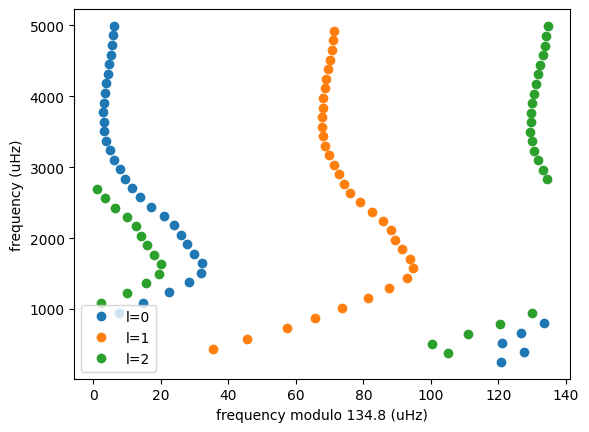

In [6]:
fig = plt.figure()

freq_mod = data.freq.real%nu0
for j in data.l:
    plt.plot(freq_mod.sel(l=j), data.freq.real.sel(l=j), 'o', color=f'C{j:d}', label=f'l={j:d}')
#     plt.plot(freq_mod.sel(l=j)-nu0, ds.freq.real.sel(l=j), 'o', color=f'C{j:d}')

plt.xlabel(f'frequency modulo {nu0:.1f} (uHz)')
plt.ylabel('frequency (uHz)')
plt.legend();

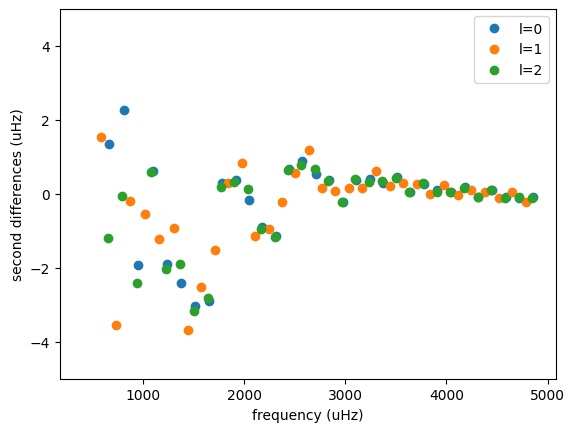

In [7]:
plt.figure()

d2nu = data.freq.real[:-2].values - 2 * data.freq.real[1:-1].values + data.freq.real[2:].values

for j in range(3):
    plt.plot(data.freq.real[1:-1, j], d2nu[:, j], 'o', color=f'C{j:d}', label=f'l={data.l[j]:d}')

plt.xlabel('frequency (uHz)')
plt.ylabel('second differences (uHz)')
plt.ylim(-5, 5)
plt.legend();

In [8]:
def split_tree_like(key, tree=None, treedef=None):
    if treedef is None:
        treedef = jax.tree_util.tree_structure(tree)
    keys = random.split(key, treedef.num_leaves)
    return tree_util.tree_unflatten(treedef, keys)

In [9]:
# class Distribution:
#     periodic = False
#     reflective = False
    
#     def transform(self, u):
#         pass

#     def log_probability(self, y):
#         pass
    
#     def sample(self, key, shape=()):
#         pass
    
#     @property
#     def mean(self):
#         pass

#     @property
#     def variance(self):
#         pass


# class Normal(Distribution):
#     def __init__(self, loc, scale):
#         self.loc = loc
#         self.scale = scale
    
#     def transform(self, u):
#         return norm.ppf(u, self.loc, self.scale)

#     def log_probability(self, y):
#         return norm.logpdf(y, self.loc, self.scale)
    
#     def sample(self, key, shape=(), dtype=jnp.float_):
#         return self.loc + self.scale * random.normal(key, shape=shape, dtype=dtype)

#     @property
#     def mean(self):
#         return self.loc

#     @property
#     def variance(self):
#         return self.scale**2


# class Uniform(Distribution):
#     def __init__(self, low=0.0, high=1.0):
#         self.low = low
#         self.high = high
#         self.loc = low
#         self.scale = high - low

#     def transform(self, u):
#         return self.loc + self.scale * u
    
#     def log_probability(self, y):
#         uniform.logpdf(y, self.loc, self.scale)

#     def sample(self, key, shape=(), dtype=jnp.float_):
#         return random.uniform(key, shape=shape, dtype=dtype, minval=self.low, maxval=self.high)
    
#     @property
#     def mean(self):
#         return (self.low + self.high) / 2.0
    
#     @property
#     def variance(self):
#         return (self.high - self.low)**2 / 12.0


# class CircularUniform(Uniform):
#     periodic = True
#     def __init__(self, low=0.0, high=2*jnp.pi):
#         super().__init__(low, high)

#     def transform(self, u):
#         # prior_transform expects u from unconstrained space for periodic distributions
#         return super().transform(jnp.mod(u, 1.0))


# class JointDistribution(Distribution):
#     def __init__(self, distributions):
#         self.distributions = distributions  # pytree structure
#         self.periodic = jax.tree_map(lambda x: x.periodic, self.distributions)
#         self.reflective = jax.tree_map(lambda x: x.reflective, self.distributions)
        
#     def transform(self, u):
#         return jax.tree_map(
#             lambda x, v: x.transform(v), 
#             self.distributions,
#             u
#         )

#     def log_probability(self, y):
#         logp = jax.tree_map(
#             lambda x, z: x.log_probability(z), 
#             self.distributions, 
#             y
#         )
#         return sum(tree_util.tree_leaves(logp))
        
#     def sample(self, key, shape=(), dtype=jnp.float_):
#         keys = split_tree_like(key, self.distributions)
#         return jax.tree_map(
#             lambda k, x: x.sample(k, shape=shape, dtype=dtype), 
#             keys,
#             self.distributions, 
#         )

#     @property
#     def mean(self):
#         return jax.tree_map(lambda x: x.mean, self.distributions)
    
#     @property
#     def variance(self):
#         return jax.tree_map(lambda x: x.variance, self.distributions)

In [10]:
PARAM_NAMES = [
    'delta_nu',
    'epsilon',
    'log_tau_he',
    'log_beta_he',
    'log_gamma_he',
    'log_alpha_cz',
    'log_tau_cz',
    'phi_he',
    'phi_cz',
    'log_sigma'
]

In [11]:
# class GlitchPrior(JointDistribution):

#     def __init__(self, delta_nu, epsilon, **distributions):

#         diff_keys = set(distributions.keys()) - set(PARAM_NAMES)
        
#         if len(diff_keys) > 0:
#             raise KeyError(
#                 f"Keys {diff_keys} are not valid parameter names for {self.__class__.__name__}. " +
#                 f"Dictionary 'distributions' may contain any of the following keys: {keys}"
#             )
        
#         distributions["delta_nu"] = delta_nu
#         distributions["epsilon"] = epsilon

#         log_tau_he = distributions.setdefault("log_tau_he", Normal(
#             jnp.log(0.2/2/delta_nu.mean),  # tau ~ 0.2 tau0
#             jnp.sqrt(0.04 + delta_nu.variance/delta_nu.mean**2)  # 0.2
#         ))
        
#         log_beta_he = distributions.setdefault("log_beta_he", Normal(
#             2*(log_tau_he.mean + jnp.log(0.1*jnp.pi)) + jnp.log(8.0),  # beta ~ 8 * (np.pi * 0.1 * tau)**2
#             jnp.sqrt(0.25 + 4*log_tau_he.variance)  # 0.5
#         ))
#         # beta = 8 * pi**2 * delta**2
        
#         distributions.setdefault("log_gamma_he", Normal(
#             0.5*(log_beta_he.mean -  jnp.log(jnp.pi)) + jnp.log(0.5*0.1), # gamma ~ 1/2 * 0.1 * sqrt(beta/pi)
#             jnp.sqrt(0.64 + 0.25*log_beta_he.variance)  # 0.8
#         ))
#         # alpha_he = (dgamma / gamma)_min = gamma_he / sqrt(2pi) / delta_he
#         # a_he = delta_nu * gamma_he
        
#         distributions.setdefault("log_alpha_cz", Normal(
#             jnp.log(delta_nu.mean*30.0), 
#             jnp.sqrt(0.64 + delta_nu.variance/delta_nu.mean**2)  # 0.8
#         ))
        
#         distributions.setdefault("log_tau_cz", Normal(
#             jnp.log(0.6/2/delta_nu.mean),  # tau ~ 0.6 tau0
#             jnp.sqrt(0.04 + delta_nu.variance/delta_nu.mean**2)  # 0.2
#         ))
        
#         distributions.setdefault("phi_he", CircularUniform())
#         distributions.setdefault("phi_cz", CircularUniform())
                
#         distributions.setdefault("log_sigma", Normal(jnp.log(0.01), 2.0))
        
#         super().__init__(distributions)

In [19]:
# def estimate_asy(n, nu, nu_err=None):
#     w = None if nu_err is None else jnp.broadcast_to(1/nu_err, nu.shape)
#     popt, pcov = jnp.polyfit(n.astype(float), nu, 1, w=w, cov=True)
#     perr = jnp.sqrt(jnp.diag(pcov))
#     delta_nu = Normal(popt[0], perr[0])
#     epsilon = Normal(popt[1]/delta_nu.mean, perr[1]/delta_nu.mean)
#     return delta_nu, epsilon

In [13]:
# class GlitchModel:
#     def __init__(self, n, nu, nu_err=None):
#         self.n = n
#         self.nu = nu
#         self.nu_err = nu_err
    
#     @staticmethod
#     def _oscillation(nu, tau, phi):
#         return jnp.sin(4 * jnp.pi * tau * nu + phi)

#     def smooth_component(self, params, n):
#         return params["delta_nu"] * (n + params["epsilon"])
    
#     def helium_amp(self, params, nu):
#         return params["delta_nu"] * jnp.exp(params["log_gamma_he"]) * nu \
#             * jnp.exp(- jnp.exp(params["log_beta_he"]) * nu**2)

#     def helium_osc(self, params, nu):
#         return self._oscillation(nu, jnp.exp(params["log_tau_he"]), params["phi_he"])

#     def helium_glitch(self, params, nu):
#         return self.helium_amp(params, nu) * self.helium_osc(params, nu)

#     def bcz_amp(self, params, nu):
#         return params["delta_nu"] * jnp.exp(params["log_alpha_cz"]) / nu**2

#     def bcz_osc(self, params, nu):
#         return self._oscillation(nu, jnp.exp(params["log_tau_cz"]), params["phi_cz"])

#     def bcz_glitch(self, params, nu):
#         return self.bcz_amp(params, nu) * self.bcz_osc(params, nu)

#     def glitch(self, params, nu):
#         return self.helium_glitch(params, nu) + self.bcz_glitch(params, nu)

#     def build_gp(self, params):
#         # kernel = jnp.exp(params["log_amp"]) * kernels.ExpSquared(jnp.exp(params["log_scale"]))
#         kernel = 0.5*params["delta_nu"] * kernels.ExpSquared(5.0)
        
#         def mean(n):
#             nu_sm = self.smooth_component(params, n)
#             dnu = self.glitch(params, nu_sm)
#             return nu_sm + dnu
        
#         diag = jnp.exp(2*params["log_sigma"])
# #         diag = 1e-4
#         if self.nu_err is not None:
#             diag += self.nu_err**2
        
#         return GaussianProcess(kernel, self.n, mean=mean, diag=diag)

#     def predict(self, params, n, **kwargs):
#         gp = self.build_gp(params)
#         _, cond = gp.condition(self.nu, n, **kwargs)
#         return cond.loc, cond.variance

# #     @partial(jax.jit, static_argnums=0)
#     def log_likelihood(self, params):
#         model = GlitchModel(params)
#         gp = self.build_gp(params)
#         return gp.log_probability(self.nu)

# #     @partial(jax.jit, static_argnums=0)
# #     def prior_transform(self, uparams):
# #         return self.prior.transform(uparams)
# # #         params = {}
# # #         for key, value in self.prior.items():
# # #             params[key] = value.prior_transform(uparams[key])

# # #         return params

# #     @partial(jax.jit, static_argnums=0)
# #     def log_prior(self, params):
# #         return self.prior.log_probability(params)
# # #         log_p = 0.0
# # #         for key, value in self.prior.items():
# # #             log_p += value.log_probability(params[key])
# # #         return log_p        

In [14]:
name = "best"

In [15]:
l = 0

if name == "worst":
    # Worst 
    n = np.arange(17, 23)
    nu_err = 1.0
elif name == "better":
    # Better
    n = np.arange(14, 26)
    nu_err = 1e-1
elif name == "best":
    # Best
    n = np.arange(11, 29)
    nu_err = 1e-2
else:
    raise ValueError("Parameter 'name' is not one of ['worst', 'better', 'best']")

In [21]:
nu_true = data.freq.real.sel(l=l, n_pg=n).values

rng, key = random.split(rng)
nu = nu_true + nu_err * random.normal(key, shape=nu_true.shape)

delta_nu, epsilon = estimate_asy(n, nu, nu_err=nu_err)

prior = GlitchPrior(delta_nu, epsilon)
model = GlitchModel(prior, n=n, nu=nu, nu_err=nu_err)

print(f"{delta_nu.mean:.2f} ± {delta_nu.variance**0.5:.2f}")

132.87 ± 0.12


In [22]:
rng, key = random.split(rng)
prior_samples = prior.sample(key, shape=(1000,))

In [23]:
def sample_predictive(key, params, n, shape=(), **kwargs):
    gp = model.build_gp(params)
    _, cond = gp.condition(model.nu, n, **kwargs)
    return cond.sample(key, shape=shape)

In [24]:
axis = jax.tree_map(lambda x: 0, prior_samples)

# Deterministic
nu_sm = jax.vmap(model.smooth_component, in_axes=(axis, None))(prior_samples, n)
dnu = jax.vmap(model.glitch, in_axes=(axis, 0))(prior_samples, nu_sm)

# Probabalistic
rng, key = random.split(rng)
keys = random.split(key, 1000)

nu_gp = jax.vmap(
    partial(sample_predictive, include_mean=False), in_axes=(0, axis, None)
)(keys, prior_samples, n)

nu_model = nu_gp + nu_sm + dnu

Text(0.5, 1.0, 'Prior predictive')

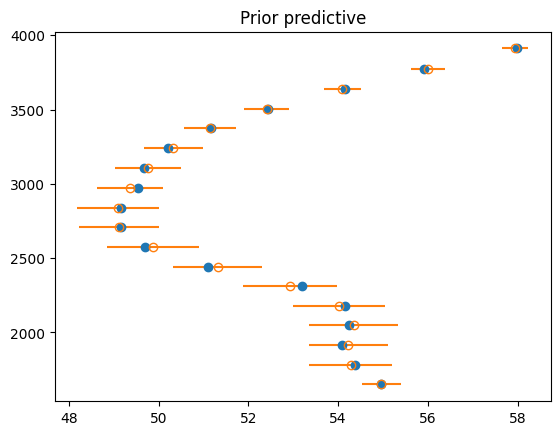

In [25]:
# init_params = prior.mean

# nu_gp, nu_var = model.predict(init_params, n, include_mean=False)
# nu_sd = np.sqrt(nu_var)
nu_mean = np.mean(nu_model, axis=0)
nu_sd = np.std(nu_model, axis=0)

plt.errorbar(nu%delta_nu.mean, nu, xerr=nu_err, fmt="o")
plt.errorbar(nu_mean%delta_nu.mean, nu_mean, xerr=nu_sd, fmt="o", markerfacecolor="none")
# plt.plot(nu_sm%delta_nu, nu_sm, "o")

plt.title("Prior predictive")

In [26]:
nu_pred = jnp.linspace(nu.min(), nu.max(), 201)
dnu_pred = jax.vmap(model.glitch, in_axes=(axis, None))(prior_samples, nu_pred)
dnu_he_pred = jax.vmap(model.helium_glitch, in_axes=(axis, None))(prior_samples, nu_pred)
dnu_cz_pred = jax.vmap(model.bcz_glitch, in_axes=(axis, None))(prior_samples, nu_pred)

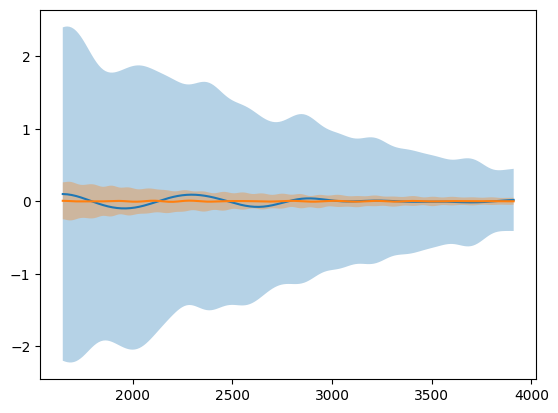

In [27]:
for d in [dnu_he_pred, dnu_cz_pred]:
    dnu_mean = d.mean(axis=0)
    dnu_sd = d.std(axis=0)

    plt.plot(
        nu_pred,
        dnu_mean,
    )

    plt.fill_between(nu_pred, dnu_mean-dnu_sd, dnu_mean+dnu_sd, alpha=0.33);

In [28]:
def nested_sampler(model, xla=True, **kwargs):
    leaves, treedef = tree_util.tree_flatten(model.prior.mean)
    ndim = len(leaves)
#     print(ndim)
    assert ndim == kwargs.pop("ndim", ndim)  # check ndims match

    def log_likelihood(x):
        params = tree_util.tree_unflatten(treedef, x)
        return model.log_likelihood(params)

    def prior_transform(u):
        uparams = tree_util.tree_unflatten(treedef, u)
        return tree_util.tree_leaves(model.prior_transform(uparams))

    _gradient = kwargs.pop("gradient", None)
    gradient = None
    if _gradient is not None:
        def gradient(u):
            uparams = tree_util.tree_unflatten(treedef, u)
            return _gradient(uparams)

    if xla:
        log_likelihood = jax.jit(log_likelihood)
        prior_transform = jax.jit(prior_transform)
        if gradient is not None:
            gradient = jax.jit(gradient)        
    
    _periodic, = np.where(tree_util.tree_leaves(model.prior.periodic))
    _reflective, = np.where(tree_util.tree_leaves(model.prior.reflective))

    if _periodic.size == 0:
        _periodic = None
    if _reflective.size == 0:
        _reflective = None
        
    periodic = kwargs.pop("periodic", _periodic)
    reflective = kwargs.pop("reflective", _reflective)
    
    return dynesty.NestedSampler(
        log_likelihood, prior_transform, ndim, gradient=_gradient,
        periodic=periodic, reflective=reflective,
        **kwargs)

In [30]:
rstate = np.random.default_rng(0)
sampler = nested_sampler(model, nlive=500, sample="rwalk", walks=50, rstate=rstate)

In [31]:
sampler.run_nested()

8326it [01:32, 90.26it/s, +500 | bound: 90 | nc: 1 | ncall: 344408 | eff(%):  2.566 | loglstar:   -inf < -1.912 <    inf | logz: -17.987 +/-  0.189 | dlogz:  0.001 >  0.509]


In [32]:
res = sampler.results

In [39]:
leaves, treedef = tree_util.tree_flatten(prior.mean)  # need to automate this

In [40]:
tree_util.tree_unflatten(treedef, list(res.samples.T))

{'delta_nu': array([132.85109549, 132.93069728, 132.86243585, ..., 132.88204894,
        132.80127876, 132.82147666]),
 'epsilon': array([1.39358393, 1.37603396, 1.38856904, ..., 1.40179859, 1.39126335,
        1.40350985]),
 'log_alpha_cz': array([9.39974023, 7.9127613 , 8.33903179, ..., 8.21030944, 8.49100411,
        8.04318398]),
 'log_beta_he': array([-15.89302807, -15.65533213, -15.82949205, ..., -14.68660773,
        -14.78466426, -14.73416336]),
 'log_gamma_he': array([ -9.26038895,  -8.55405957,  -9.46984766, ..., -10.92105504,
        -11.14808674, -10.99387226]),
 'log_sigma': array([-7.00993585, -4.98927636, -6.21032083, ..., -2.81427978,
        -2.81247562, -2.96241029]),
 'log_tau_cz': array([-6.1283767 , -6.0006683 , -6.36893741, ..., -6.49349713,
        -6.48366654, -6.50046752]),
 'log_tau_he': array([-7.09132986, -7.30543147, -7.13816243, ..., -7.23851998,
        -7.19683767, -7.25270891]),
 'phi_cz': array([5.02823906, 0.89358128, 4.21631312, ..., 1.5161997 , 1.25

In [ ]:
samples_flat, weights = res.samples, res.importance_weights()
samples_equal = dynesty.utils.resample_equal(samples_flat, weights)
samples = tree_util.tree_unflatten(treedef, list(samples_equal.T))

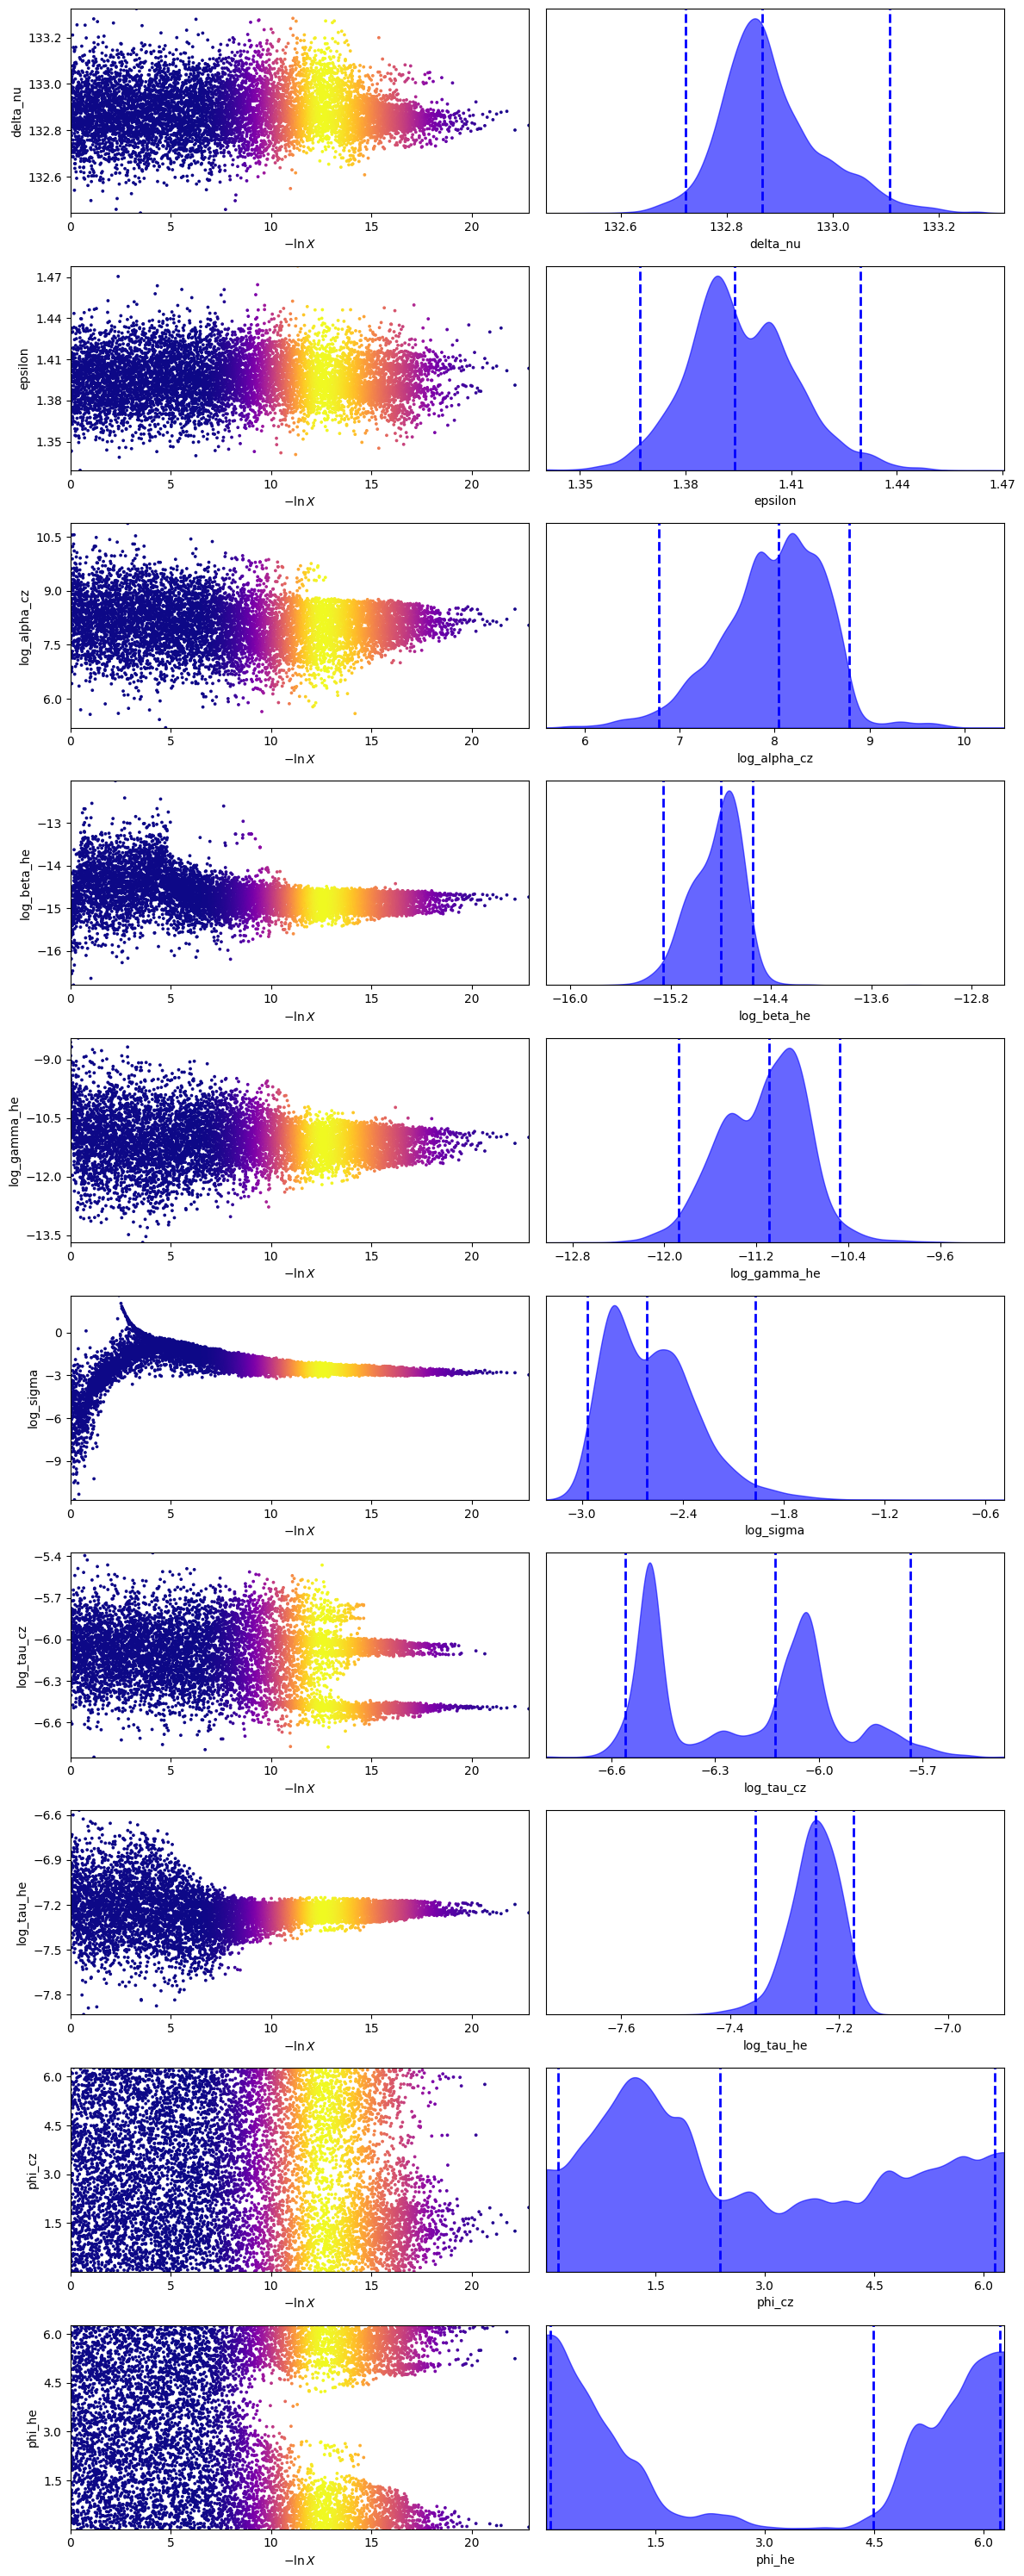

In [35]:
labels = tree_util.tree_leaves({k: k for k in prior.distributions.keys()})
# truths = tree_util.tree_leaves(true_params)
fig, axes = dyplot.traceplot(res, labels=labels)  #, fig=plt.subplots(3, 2, figsize=(16, 12)))
fig.tight_layout()

In [36]:
jnp.exp(jax.tree_map(jnp.add, prior.mean, prior.variance)["log_tau_cz"])

Array(0.00234995, dtype=float64)

In [37]:
jnp.exp(jax.tree_map(jnp.subtract, prior.mean, prior.variance)["log_tau_cz"])

Array(0.00216927, dtype=float64)

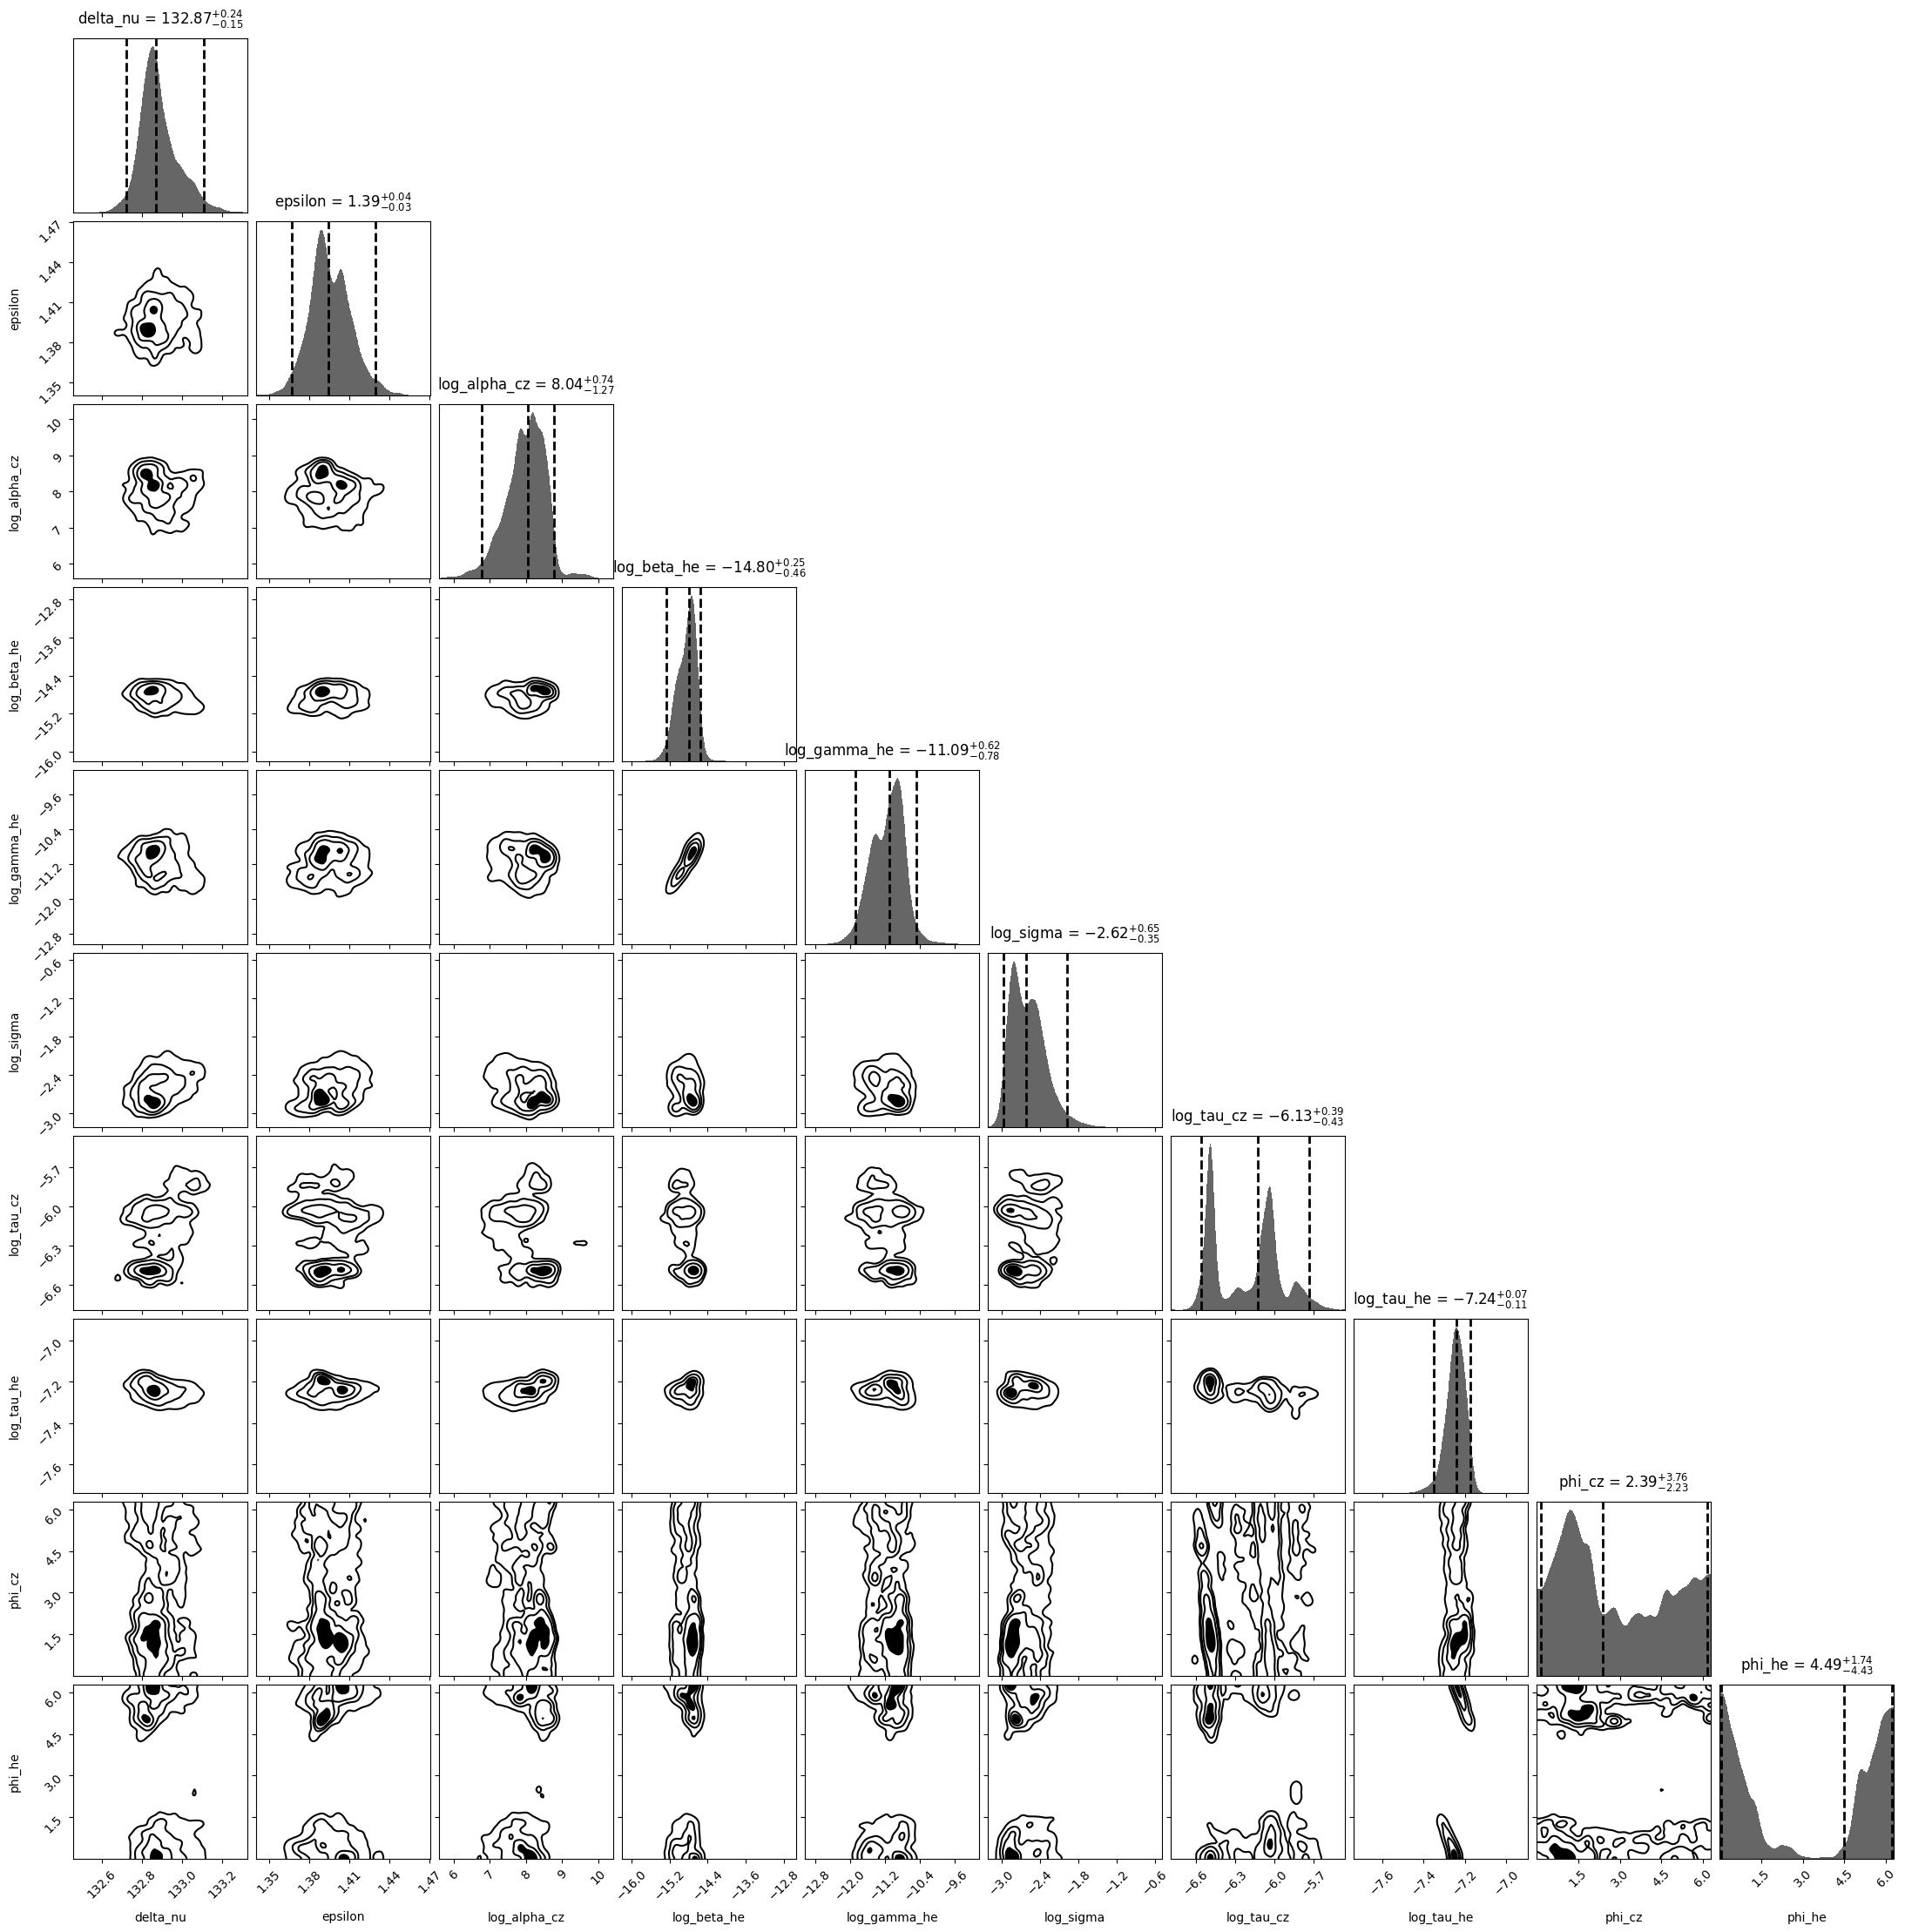

In [38]:
fig, axes = dyplot.cornerplot(res, show_titles=True, title_kwargs={'y': 1.04}, labels=labels)

In [41]:
samples_flat, weights = res.samples, res.importance_weights()
samples_equal = dynesty.utils.resample_equal(samples_flat, weights)
samples = tree_util.tree_unflatten(treedef, list(samples_equal.T))

In [42]:
np.exp(samples["log_tau_he"]).mean()

0.0007137985331646725

In [43]:
np.median(np.exp(samples["log_tau_cz"]))

0.0021832346039980027

In [44]:
dnu = jax.vmap(model.glitch, in_axes=(0, None))(samples, nu_pred)
dnu_med = np.median(dnu, axis=0)
dnu_lower, dnu_upper = np.quantile(dnu, [.16, .84], axis=0)

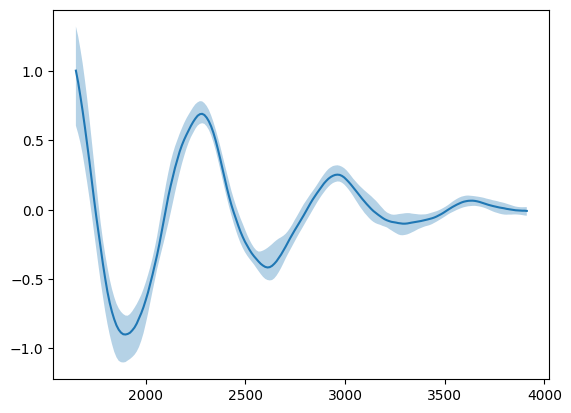

In [45]:
plt.plot(nu_pred, dnu_med)
plt.fill_between(nu_pred, dnu_lower, dnu_upper, alpha=0.33)

(-2.0, 2.0)

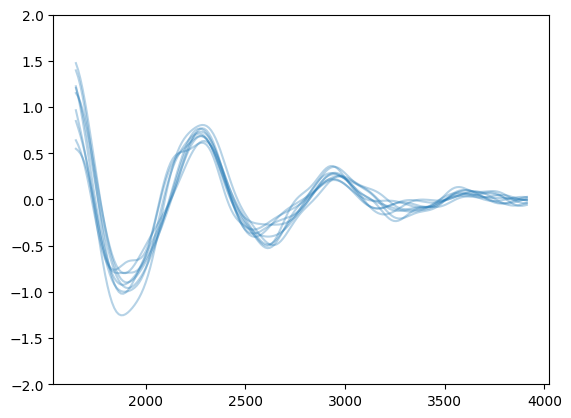

In [46]:
thin = 1000
y = dnu[::thin]
x = np.broadcast_to(nu_pred, y.shape)
plt.plot(x.T, y.T, color="C0", alpha=0.33);
plt.ylim(-2, 2)

In [47]:
med = jax.tree_map(np.median, samples)
low = jax.tree_map(lambda x: np.quantile(x, .16), samples)
upp = jax.tree_map(lambda x: np.quantile(x, .84), samples)

In [48]:
def to_sec(log_tau):
    return 1e6*np.exp(log_tau)

Text(0, 0.5, 'density gradient')

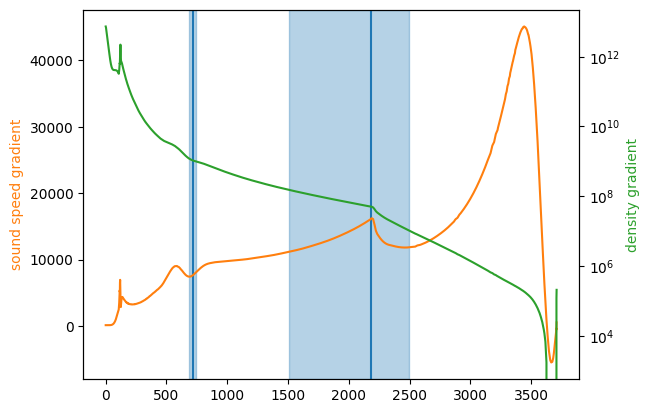

In [49]:
fig, ax = plt.subplots()


for g in ["he", "cz"]:
    ax.axvline(to_sec(med[f"log_tau_{g}"]), color="C0")
    ax.axvspan(to_sec(low[f"log_tau_{g}"]), to_sec(upp[f"log_tau_{g}"]), 
               color="C0", alpha=0.33)

ax.plot(data.tau, differentiate(data.cs, data.tau), color="C1")
ax.set_ylabel("sound speed gradient", color="C1")

ax = ax.twinx()

ax.plot(data.tau, differentiate(data.cs, data.rho), color="C2")
ax.set_yscale("log")
ax.set_ylabel("density gradient", color="C2")

In [50]:
gamma_he = 1e6*jnp.exp(samples["log_gamma_he"])
delta_he = 1e6*jnp.exp(0.5*samples["log_beta_he"])*jnp.sqrt(2)/4/np.pi  # width
tau_he = 1e6*jnp.exp(samples["log_tau_he"])  # location

In [51]:
dgamma_gamma = - gamma_he[:, None] * jax.vmap(norm.pdf, in_axes=(None, 0, 0))(data.tau.values, tau_he, delta_he)

In [52]:
dg_med = np.median(dgamma_gamma, axis=0)
dg_low, dg_upp = np.quantile(dgamma_gamma, [.16, .84], axis=0)

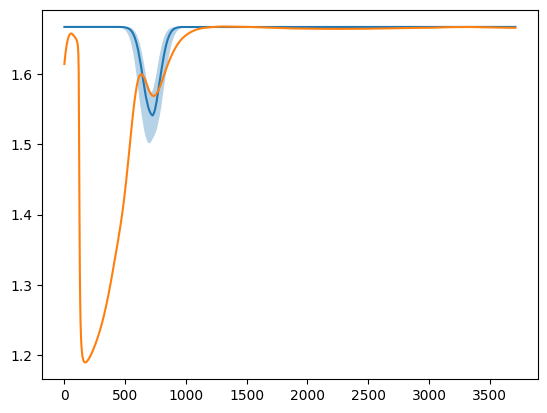

In [53]:
offset = 5/3
plt.plot(data.tau, offset+data.Gamma_1*dg_med)
plt.fill_between(data.tau, offset+data.Gamma_1*dg_low, offset+data.Gamma_1*dg_upp, alpha=0.33)
plt.plot(data.tau, data.Gamma_1)